# Multi-objective robust decision making (MORDM)

This file applies MOR-DM techniques to analyze and visualize the performance of policies under uncertainty. It focuses on identifying robust solutions by evaluating trade-offs across multiple outcomes using parallel coordinate plots.

## Step 1: Problem formulation

The problem formulation is chosen based on the expectation of the stakeholder.

In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [7]:
from ema_workbench import (Model, RealParameter, CategoricalParameter, IntegerParameter, ScalarOutcome)
from dike_model_function import DikeNetwork

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, ArrayOutcome, ScalarOutcome, Policy,
                           RealParameter, CategoricalParameter, IntegerParameter, optimize, Scenario)

from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties, LHSSampler
from ema_workbench.em_framework.salib_samplers import SobolSampler, MorrisSampler
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim

from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

# Make model
dike_model = Model('dikeproblem', function=DikeNetwork())

# Set uncertainties
dike_model.uncertainties = [
    # Uncertainties per dike
    RealParameter('A.1_Bmax', 30, 350),
    RealParameter('A.1_pfail', 0, 1),
    CategoricalParameter('A.1_Brate', [1.0, 1.5, 10]),

    RealParameter('A.2_Bmax', 30, 350),
    RealParameter('A.2_pfail', 0, 1),
    CategoricalParameter('A.2_Brate', [1.0, 1.5, 10]),

    RealParameter('A.3_Bmax', 30, 350),
    RealParameter('A.3_pfail', 0, 1),
    CategoricalParameter('A.3_Brate', [1.0, 1.5, 10]),

    RealParameter('A.4_Bmax', 30, 350),
    RealParameter('A.4_pfail', 0, 1),
    CategoricalParameter('A.4_Brate', [1.0, 1.5, 10]),

    RealParameter('A.5_Bmax', 30, 350),
    RealParameter('A.5_pfail', 0, 1),
    CategoricalParameter('A.5_Brate', [1.0, 1.5, 10]),

    # Discount rate per planning step (planning_steps = [0,1,2])
    CategoricalParameter('discount rate 0', [1.5, 2.5, 3.5, 4.5]),
    CategoricalParameter('discount rate 1', [1.5, 2.5, 3.5, 4.5]),
    CategoricalParameter('discount rate 2', [1.5, 2.5, 3.5, 4.5]),

    # Flood wave shape
    IntegerParameter('A.0_ID flood wave shape', 0, 132)
]

# Set levers
dike_model.levers = [
    # DikeIncrease per dike and per planning step
    IntegerParameter('A.1_DikeIncrease 0', 0, 10),
    IntegerParameter('A.1_DikeIncrease 1', 0, 10),
    IntegerParameter('A.1_DikeIncrease 2', 0, 10),

    IntegerParameter('A.2_DikeIncrease 0', 0, 10),
    IntegerParameter('A.2_DikeIncrease 1', 0, 10),
    IntegerParameter('A.2_DikeIncrease 2', 0, 10),

    IntegerParameter('A.3_DikeIncrease 0', 0, 10),
    IntegerParameter('A.3_DikeIncrease 1', 0, 10),
    IntegerParameter('A.3_DikeIncrease 2', 0, 10),

    IntegerParameter('A.4_DikeIncrease 0', 0, 10),
    IntegerParameter('A.4_DikeIncrease 1', 0, 10),
    IntegerParameter('A.4_DikeIncrease 2', 0, 10),

    IntegerParameter('A.5_DikeIncrease 0', 0, 10),
    IntegerParameter('A.5_DikeIncrease 1', 0, 10),
    IntegerParameter('A.5_DikeIncrease 2', 0, 10),

    # RfR per project en per planning step (5 projecten: 0 t/m 4)
    IntegerParameter('0_RfR 0', 0, 1),
    IntegerParameter('0_RfR 1', 0, 1),
    IntegerParameter('0_RfR 2', 0, 1),

    IntegerParameter('1_RfR 0', 0, 1),
    IntegerParameter('1_RfR 1', 0, 1),
    IntegerParameter('1_RfR 2', 0, 1),

    IntegerParameter('2_RfR 0', 0, 1),
    IntegerParameter('2_RfR 1', 0, 1),
    IntegerParameter('2_RfR 2', 0, 1),

    IntegerParameter('3_RfR 0', 0, 1),
    IntegerParameter('3_RfR 1', 0, 1),
    IntegerParameter('3_RfR 2', 0, 1),

    IntegerParameter('4_RfR 0', 0, 1),
    IntegerParameter('4_RfR 1', 0, 1),
    IntegerParameter('4_RfR 2', 0, 1),

    # Early Warning System
    IntegerParameter('EWS_DaysToThreat', 0, 4)
]


# Set outcomes
damage_variables = [f"{dike}_Expected Annual Damage" for dike in ['A.4', 'A.5']]
rfr_cost_variables = ["RfR Total Costs"]
dike_cost_variables = [f"{dike}_Dike Investment Costs" for dike in ['A.4', 'A.5']]

dike_model.outcomes = [
    ScalarOutcome(
        "Expected Annual Damage",
        variable_name=damage_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
    ScalarOutcome(
        "RfR Total Costs",
        variable_name=rfr_cost_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
    ScalarOutcome(
        "Dike Investment Costs",
        variable_name=dike_cost_variables,
        kind=ScalarOutcome.MINIMIZE,
        function=sum_over,
    ),
]


## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. Different epsilon values are used, to see which one gives the best results.


In [8]:
# Setting up the reference scenario - needed for MORDM
reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate': 3.5,
                    'ID flood wave shape': 4}

# Definition of scenario-dictionary for later creation of policy class-instance for reference scenario
scen1 = {}

# Reference scenario updated for all dike rings
for key in dike_model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in reference_values.keys():
            scen1.update({key.name: reference_values[name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

# Set reference scenario
ref_scenario = Scenario('reference', **scen1)

# set convergence metrics
convergence_metrics = [EpsilonProgress()]

nfe = 100000

Now, we do it first with epsilon 0.1, and then with epsilon 0.01, to choose which one can give the best results.

In [9]:
# Run optimization with epsilon = 0.1
if __name__ == '__main__':
    with MultiprocessingEvaluator(dike_model) as evaluator:
            results1, convergence = evaluator.optimize(nfe=nfe,
                                                      searchover='levers',
                                                      epsilons=[0.1,]*len(dike_model.outcomes),
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario
                                                      )

100%|████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


In [10]:
# Run optimization with epsilon = 0.01
if __name__ == '__main__':
    with MultiprocessingEvaluator(dike_model) as evaluator:
            results2, convergence = evaluator.optimize(nfe=nfe,
                                                      searchover='levers',
                                                      epsilons=[0.01,]*len(dike_model.outcomes),
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario
                                                      )

100%|████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


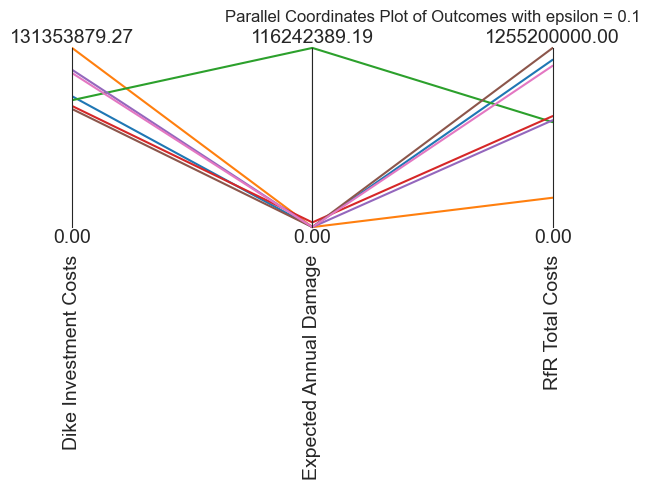

In [11]:
# Select relevant outcome columns for visualization
data1 = results1.loc[:, [
    "Dike Investment Costs",
    "Expected Annual Damage",
    "RfR Total Costs",
]]

# Get axis limits for the parallel coordinates plot
limits1 = parcoords.get_limits(data1)

# Set minimum values (lower bounds) for selected outcomes to 0
limits1.loc[0, [
    "Dike Investment Costs",
    "Expected Annual Damage",
    "RfR Total Costs",
]] = 0

# Create and plot the parallel axes for the selected outcomes
paraxes1 = parcoords.ParallelAxes(limits1)
paraxes1.plot(data1)
plt.title("Parallel Coordinates Plot of Outcomes with epsilon = 0.1")
plt.show()

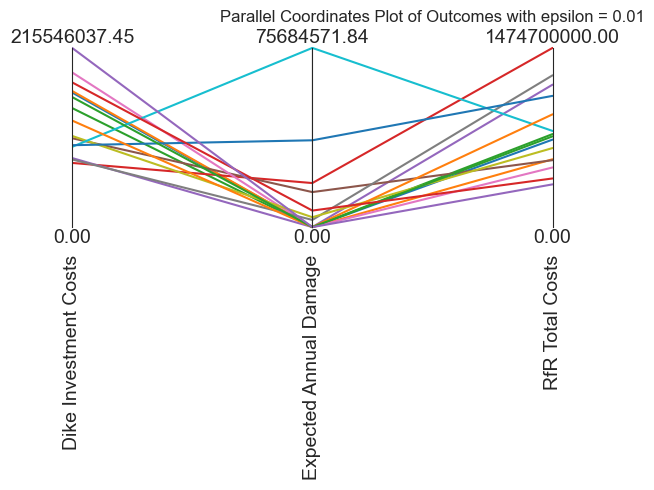

In [12]:
# Select relevant outcome columns for visualization
data2 = results2.loc[:, [
    "Dike Investment Costs",
    "Expected Annual Damage",
    "RfR Total Costs",
]]

# Get axis limits for the parallel coordinates plot
limits2 = parcoords.get_limits(data2)

# Set minimum values (lower bounds) for selected outcomes to 0
limits2.loc[0, [
    "Dike Investment Costs",
    "Expected Annual Damage",
    "RfR Total Costs",
]] = 0

# Create and plot the parallel axes for the selected outcomes
paraxes2 = parcoords.ParallelAxes(limits2)
paraxes2.plot(data2)
plt.title("Parallel Coordinates Plot of Outcomes with epsilon = 0.01")
plt.show()

As can be seen, epsilon 0.01 gives more results. So, the next part will go further with those results.

## Step 3: Re-evaluate candidate solutions under uncertainty

We apply a constraint on Dike Investment Costs to filter out policies that exceed the budget threshold.
The remaining policies are reformatted and re-evaluated over 1000 scenarios using the EMA Workbench.
This allows us to analyze the robustness of cost-effective policies under deep uncertainty.



In [25]:
# Create a boolean mask for policies with Expected Annual Damage below €25000000
logical = results2['Expected Annual Damage'] < 25000000

# Filter the results to include only the cost-effective policies
results2[logical]

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,...,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,Expected Annual Damage,RfR Total Costs,Dike Investment Costs
0,0,6,2,4,5,8,6,0,4,5,...,0,0,0,0,0,0,0,0.000000e+00,7.201000e+08,1.619270e+08
1,4,1,5,8,8,5,9,1,5,7,...,0,0,0,0,1,0,2,0.000000e+00,5.585000e+08,1.637726e+08
2,9,8,6,6,8,4,10,7,10,10,...,1,1,1,0,0,1,1,0.000000e+00,7.657000e+08,1.432075e+08
3,2,6,4,0,10,7,2,2,9,5,...,0,1,1,1,1,0,3,1.860486e+07,1.474700e+09,7.720088e+07
4,7,1,4,2,0,2,9,7,2,5,...,1,1,0,1,0,1,4,0.000000e+00,1.172300e+09,8.308456e+07
5,4,4,7,10,7,5,3,4,3,0,...,0,0,0,0,0,0,0,1.479471e+07,5.509000e+08,1.069031e+08
6,4,1,6,2,9,1,4,0,0,7,...,0,1,1,0,0,0,4,0.000000e+00,4.909000e+08,1.860688e+08
7,10,4,3,5,6,8,7,2,2,0,...,1,0,1,1,0,0,0,3.036714e+06,1.249300e+09,8.138057e+07
8,1,5,7,1,4,9,5,6,9,1,...,0,0,0,0,1,0,0,4.180587e+06,6.506000e+08,1.096743e+08
11,5,2,1,2,10,7,10,6,7,4,...,0,0,1,0,1,0,1,0.000000e+00,9.282000e+08,1.281806e+08


In [26]:
# Select the filtered policies that meet the cost constraint
policies = results2[logical]

# Remove outcome columns to keep only policy input parameters
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)

# Display the resulting policies dataframe
policies

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,...,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat
0,0,6,2,4,5,8,6,0,4,5,...,1,0,0,0,0,0,0,0,0,0
1,4,1,5,8,8,5,9,1,5,7,...,0,0,0,0,0,0,0,1,0,2
2,9,8,6,6,8,4,10,7,10,10,...,1,0,1,1,1,1,0,0,1,1
3,2,6,4,0,10,7,2,2,9,5,...,0,0,1,0,1,1,1,1,0,3
4,7,1,4,2,0,2,9,7,2,5,...,1,0,0,1,1,0,1,0,1,4
5,4,4,7,10,7,5,3,4,3,0,...,0,0,1,0,0,0,0,0,0,0
6,4,1,6,2,9,1,4,0,0,7,...,0,1,0,0,1,1,0,0,0,4
7,10,4,3,5,6,8,7,2,2,0,...,1,1,0,1,0,1,1,0,0,0
8,1,5,7,1,4,9,5,6,9,1,...,1,1,1,0,0,0,0,1,0,0
11,5,2,1,2,10,7,10,6,7,4,...,0,0,1,0,0,1,0,1,0,1


In [27]:
from ema_workbench import Policy

# Make each policy row into a Policy object for EMA Workbench evaluation
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [28]:
# Define the number of scenarios to run per policy
n_scenarios = 1000

# Run the model evaluations for the selected policies and scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

100%|████████████████████████████████████████| 130/130 [01:13<00:00,  1.76it/s]


**Signal-to-noise ratio**

We evaluate the robustness of each policy by analyzing its performance across 1000 scenarios, focusing on our outcomes. Robustness is quantified using the signal-to-noise ratio, which balances the mean outcome against its standard deviation, with different formulations depending on whether the outcome should be maximized or minimized. By calculating these ratios for all outcomes and policies, we can visualize trade-offs and identify policies that offer good compromises.

In [29]:
def s_to_n(data, direction):
    # Calculate mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # Avoid division by zero if std is zero
    if std==0:
        std = 1

    # For outcomes to maximize, use mean divided by std
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        # For outcomes to minimize, use mean multiplied by std
        return mean*std
    

The signal-to-noise ratio is calculated for each policy and each outcome using the results for that policy. The direction of the outcome tells how to calculate the ratio, so the code does not need to be repeated. All the results are put into a dataframe to make visualization easier.

In [30]:
experiments, outcomes = results

# Initialize dictionary to store signal-to-noise scores for each policy
overall_scores = {}

# Loop over each unique policy
for policy in np.unique(experiments['policy']):
    scores = {}

    # Select experiments corresponding to the current policy
    logical = experiments['policy']==policy

    # Calculate signal-to-noise ratio for each outcome of the policy
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio

    # Store the scores for this policy
    overall_scores[policy] = scores

# Convert the scores dictionary to a DataFrame and transpose
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,RfR Total Costs,Dike Investment Costs
0,1.294285e+12,7.201000e+08,1.619270e+08
1,1.118962e+14,5.585000e+08,4.880803e+00
11,2.197337e+11,9.282000e+08,1.281806e+08
12,0.000000e+00,7.470000e+08,1.564369e+08
13,1.003186e+15,4.004000e+08,1.740965e+08
14,3.970661e+12,3.518000e+08,2.155460e+08
2,3.281588e+12,7.657000e+08,4.267915e+00
3,1.942120e+15,1.474700e+09,1.150383e+00
4,2.238548e+12,1.172300e+09,8.308456e+07
5,2.311492e+14,5.509000e+08,1.592980e+00


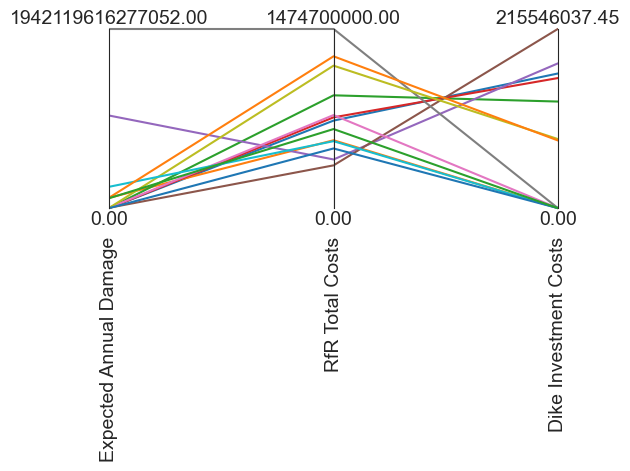

In [31]:
from ema_workbench.analysis import parcoords

# Use the calculated scores as data for the parallel coordinates plot
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, [
    "Expected Annual Damage",
    "RfR Total Costs",
    "Dike Investment Costs",
] ] = 0

# Plot the data showing trade-offs across outcomes for each policy
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

**Maximum regret**

Maximum regret measures the worst-case difference between a policy’s performance and the best possible outcome across all scenarios. It is calculated for each policy and outcome, favoring policies with lower maximum regret values. These values can be visualized using parallel plots to identify policies that balance trade-offs effectively.

In [21]:
def calculate_regret(data, best):
    return np.abs(best-data)

Regret is the absolute difference between a policy’s outcome and the best possible outcome in each scenario, regardless of whether the outcome is to be minimized or maximized. This allows calculating the best value across policies for each scenario efficiently.

In [22]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # Create a DataFrame with relevant data: outcome values, policy names, and scenario IDs
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name],
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })

    # Pivot the DataFrame to have scenarios as rows and policies as columns
    data = data.pivot(index='scenario', columns='policy')

    # Flatten the hierarchical column index created by pivoting
    data.columns = data.columns.get_level_values(1)

    # Calculate regret as the absolute difference between the best value per scenario and each policy's value
    # Use np.newaxis to align shapes for broadcasting
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

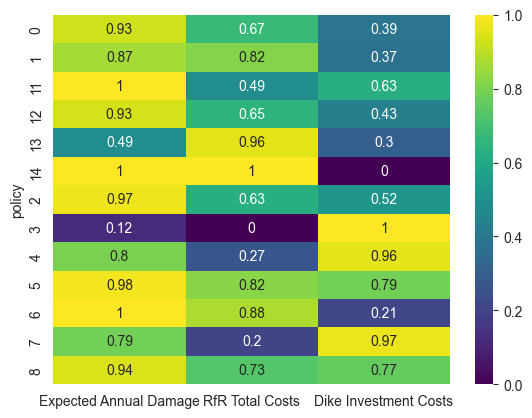

In [23]:
# Convert max_regret dictionary to a DataFrame for heatmap visualization
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

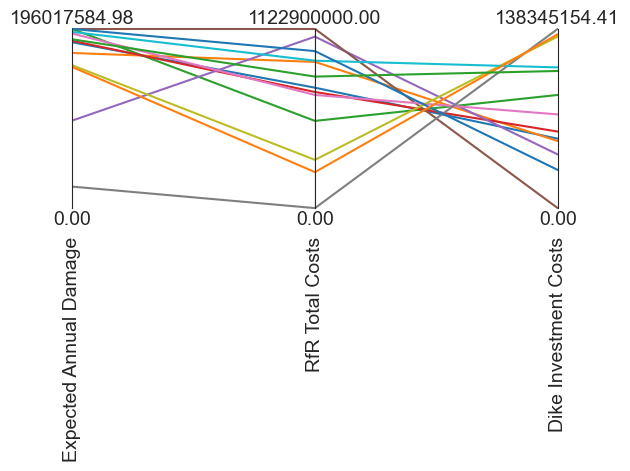

In [24]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, [
    "Expected Annual Damage",
    "RfR Total Costs",
    "Dike Investment Costs",
]] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index))
plt.show()